# **Deep Learning Model**

## **Table of contents**

* [Our goals](#Our-goals)
* [Real case application and choice of the metric](#Real-case-application-and-choice-of-the-metric)
* [Methodology](#Methodology)
    * [The data](#The-data)
    * [The tokenizer](#The-tokenizer)
    * [Setting up the datasets and the datamodule](#Setting-up-the-datasets-and-the-datamodule)
    * [The models](#The-models)
    * [Optimizer and scheduler](#Optimizer-and-scheduler)
    * [Callbacks and logger](#Callbacks-and-logger)
    * [The training](#The-training)
* [Model selection review](#Model-selection-review)
* [Investigating the mistakes](#Investigating-the-mistakes)
* [Model explainability](#Model-explainability)
* [Conclusion and future works](#Conclusion-and-future-works)

In [1]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    plot_utilities, 
    preprocessing_utilities,
    ml_utilities,
    dl_data_utilities,
    dl_model_utilities,
    dl_classifier_utilities,
    dl_callbacks_utilities
)

from utilities.plot_utilities import (
    Rstyle_spines,
    plot_classifiers_scores,
    is_light_or_dark,
    
)

from utilities.preprocessing_utilities import (
    parallel_process,
    clean_final_text_batch_spacy,
    extract_alternative_features
)

from utilities.ml_utilities import generate_augmented_datasets

from utilities.dl_data_utilities import (
    anonymize_texts_parallel,
    NewsTextDataset,
    NewsTextDataModule,
    number_of_tokens
)

from utilities.dl_model_utilities import DistilBERTWDropout
from utilities.dl_classifier_utilities import TextNewsModule
from utilities.dl_callbacks_utilities import ModelTracker

import regex as re
from functools import partial
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import torch
import lightning as L
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping

import lime
from lime.lime_text import LimeTextExplainer
import lime.lime_text

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
torch.set_float32_matmul_precision("medium")

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print("Cell skipped.")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/czank/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook, we will:  
* Prepare our data to help our model train and generalize well.  
* Present our multi-step work pipeline, designed to be highly flexible and exportable for other uses.  
* Discuss our decision to use memory-efficient models such as DistilBERT.  
* Train multiple DistilBERT-based models with different hyperparameters.  
* Review and compare all trained models before making our final choice.  
* Investigate the mistakes made by our best model.  
* Use LIME to gain insights into how our model works and compare it with our previous ML model.
</div>

## **Methodology**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
In this section, we will explain how the data was chosen and preprocessed, and more importantly, how to use the Lightning-based framework we designed to simplify the training and testing of our model. It also includes additional utilities for storing and tracking all our models.
</div>

### **The parameters**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Our model will depend on several parameters (hyperparameters). This notebook is designed to be very easy to use, and the following cell is essentially the only part that needs to be modified (apart from the model class, if one wishes to try a different model class). Each parameter has a self-explanatory name, and most will be explained later.
</div>

In [2]:
RANDOM_STATE = 42
TOKEN_MAX = 256
BATCH_SIZE = 32
N_EPOCHS = 20
DROPOUT_RATE = 0.1
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MONITOR = {'metric': 'val_f1_score', 'mode': 'max'}
MODEL_NAME = f"DistilBERT_{TOKEN_MAX}_{BATCH_SIZE}_{LEARNING_RATE}_{DROPOUT_RATE}"
print(f"Using device: {DEVICE}")

Using device: cuda


### **The data**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We've already discussed the data in the EDA and Machine Learning notebooks. A Deep Learning model requires less preprocessing since, thanks to its transformer-based nature, it benefits from having the context of a text through the attention mechanism.

First, we will once again construct our dataset, augmented with the rewritten news, as we believe this can help our model generalize better. Once this is done, we will split our training dataset into training and validation sets. Since training a Deep Learning model is slow, we will not use extensive cross-validation but instead rely on a simple 80% training and 20% validation split.

Once the latter is done, we will clean our training set. As mentioned, this preprocessing is minimal compared to what we did for the ML model. We will simply remove extra blank spaces and anonymize the names of political figures—especially those frequently appearing in our dataset, such as Trump, Clinton, or Obama. Additionally, we will anonymize organization names. For instance, a political figure will be replaced with a \[PERSON\] token, while an organization will be replaced with a \[ORG\] token, and so on. The only other cleaning step will be removing extra white spaces.
</div>

In [3]:
train_set = pd.read_csv("../data/train_set.csv", index_col=0)
test_set = pd.read_csv("../data/test_set.csv", index_col=0)
augmented_train_set, augmented_test_set = generate_augmented_datasets(train_set, test_set)

cleaned_train_set = augmented_train_set.copy()
cleaned_train_set["text"] = anonymize_texts_parallel(cleaned_train_set["text"], num_workers=20)

cleaned_train, cleaned_val = train_test_split(cleaned_train_set, test_size=0.2, random_state=RANDOM_STATE)
X_train = cleaned_train["text"]
y_train = cleaned_train["label"]
X_val = cleaned_val["text"]
y_val = cleaned_val["label"]
X_test = augmented_test_set["text"]
y_test = augmented_test_set["label"]

### **The tokenizer**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We cannot feed our model with raw text directly; it must first go through a tokenizer. Since we are using a DistilBERT-based model, we have chosen the cased DistilBERT tokenizer. Whether a word is capitalized or not may impact the model's understanding, so we opted for the cased tokenizer.
</div>

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We've seen in previous notebooks that our dataset contains texts of varying lengths, regardless of whether they are fake or true news. An important parameter for our model will be the maximum number of allowed tokens, as it can impact both its predictive performance and its computational efficiency. The higher the token limit, the better the model may capture context, but it will also slow down processing.
</div>

Token indices sequence length is longer than the specified maximum sequence length for this model (1335 > 512). Running this sequence through the model will result in indexing errors


Text(0, 0.5, 'Distribution of the number of tokens')

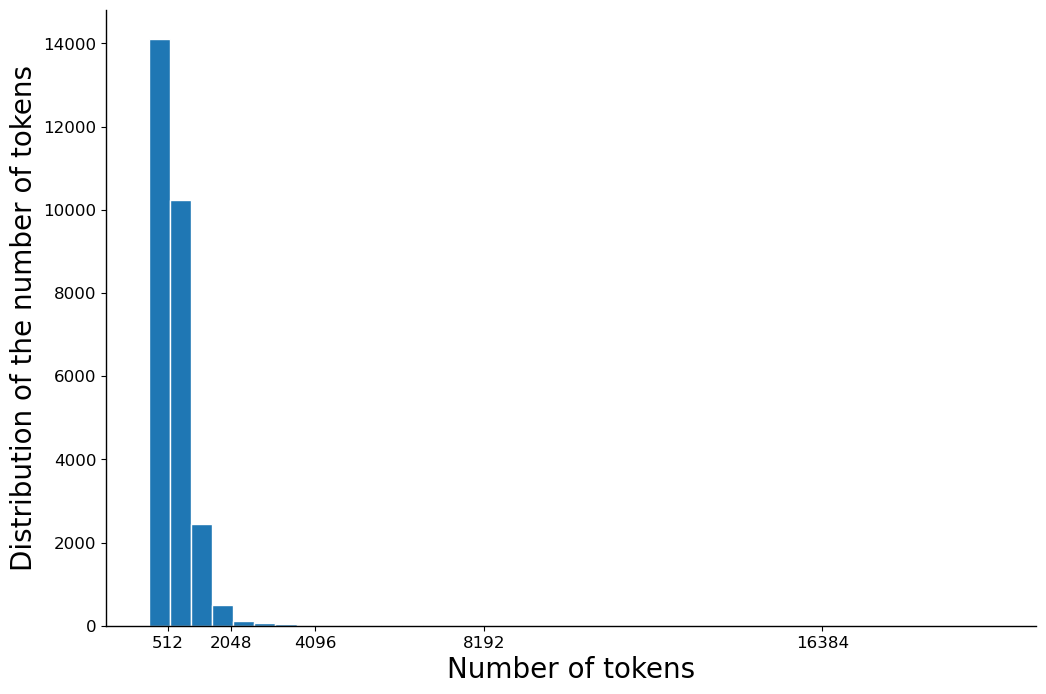

In [5]:
number_tokens = cleaned_train["text"].apply(partial(number_of_tokens, tokenizer=tokenizer))
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(number_tokens, bins=40, edgecolor="w")
ax.set_xticks([512, 2048, 4096, 8192, 16384])
ax.set_xticklabels([512, 2048, 4096, 8192, 16384])
Rstyle_spines(ax, lw=1)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Number of tokens", fontsize=20)
ax.set_ylabel("Distribution of the number of tokens", fontsize=20)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The histogram above clearly shows that, with our preprocessing and tokenizer, a significant proportion of news articles will still exceed the maximum limit of 512 tokens allowed for a DistilBERT model. Nevertheless, we will proceed with this model and rely solely on the information contained in the beginning of the text.
</div>

### **Setting up the datasets and the datamodule**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Now, using the `NewsTextDataset` and `NewsTextDataModule` from the `../utilities/dl_data_utilities.py` file, we will set up our dataset and dataloader to integrate with the PyTorch Lightning pipeline. As we can see, the maximum number of tokens (along with the tokenizer) will be a parameter, as well as the batch size, which we will also vary. Since we are training our model on a laptop with a single 8GB GPU, we must carefully manage these parameters to ensure that the memory load does not exceed the GPU’s capacity.
</div>

In [6]:
train_dataset = NewsTextDataset(
  tokenizer=tokenizer,
  ids=np.array(X_train.index),
  texts=np.array(X_train),
  labels=np.array(y_train),
  max_token_len=TOKEN_MAX
)

val_dataset = NewsTextDataset(
  tokenizer=tokenizer,
  ids=np.array(X_val.index),
  texts=np.array(X_val),
  labels=np.array(y_val),
  max_token_len=TOKEN_MAX
)

test_dataset = NewsTextDataset(
  tokenizer=tokenizer,
  ids=np.array(X_test.index),
  texts=np.array(X_test),
  labels=np.array(y_test),
  max_token_len=TOKEN_MAX
)

data_module = NewsTextDataModule(train_dataset, 
                   val_dataset, 
                   test_dataset,
                   batch_size=BATCH_SIZE)

### **The models**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Now that the data pipeline is set up, we need to instantiate our model. We've designed an adjustable DistilBERT-based model, DistilBERTWDropout, which can be found in dl_model_utilities.py. It is a simple DistilBERT model followed by a classification layer with a single output, preceded by a dropout layer with a default rate of 0.1. The dropout layer is traditionally used to reduce overfitting and improve classifier performance. Additionally, the model is designed to allow adjustments to the number of input tokens.
</div>

In [7]:
model = DistilBERTWDropout(max_tokens=TOKEN_MAX, dropout_rate=DROPOUT_RATE)

Some weights of DistilBertModel were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized because the shapes did not match:
- distilbert.embeddings.position_embeddings.weight: found shape torch.Size([512, 768]) in the checkpoint and torch.Size([256, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We also need to instantiate a criterion, i.e., a loss function. Since we're dealing with a binary classification problem, we have chosen `BCEWithLogitsLoss`, which quantifies the loss using Binary Cross Entropy but is preceded by a sigmoid layer.  

Additionally, since our dataset is globally balanced, we won’t need to adjust the class weights, though it remains an option if necessary.
</div>

In [8]:
criterion = torch.nn.BCEWithLogitsLoss()

### **Optimizer and scheduler**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

The optimizer and schedulers are crucial components of any deep learning model training. Throughout this process, we will use the AdamW optimizer, which is widely regarded in the literature as the best option for fine-tuning large models.  

A scheduler can also enhance training performance, and we have chosen a linear schedule with warmup. Our model will begin with a very low learning rate compared to the optimizer's initial learning rate, gradually increasing linearly until it reaches this value. Once it does, the learning rate will then decrease linearly. This approach helps balance training by allowing the model to escape potential local minima while preventing it from diverging too far.
</div>

In [9]:
total_training_steps = X_train.shape[0] // BATCH_SIZE * N_EPOCHS
warmup_steps = total_training_steps // 5

optimizer = AdamW(params=model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

### **Callbacks and logger**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

The Lightning framework offers a wide range of possible callbacks, as well as the ability to design custom ones. For this task, we will use three callbacks. 

The first, `checkpoint_callback` (`ModelCheckpoint`), will track and save the best snapshot of our model during training. It will also automatically reload the model from its last saved point, i.e., from its best performance configuration.

The second callback, `early_stopping` (`EarlyStopping`), monitors the performance of our model based on a defined metric. In our case, we've chosen the F1-score on the validation set, and we aim to maximize it. If the chosen metric stops improving (or decreasing if we aim to minimize it) for a number of epochs equal to or greater than the `patience` parameter, the `early_stopping` callback will stop the training. This helps prevent overfitting.

The final callback is a custom one called `ModelTracker`, whose class definition can be found in `dl_callbacks_utilities.py`. Once a model is trained, tested, and saved, it logs several important metrics (such as overall performance, model name, configuration, training time, etc.) to a local CSV file named `model_selection_log.csv`. This allows us to track and compare the performance of all the models that were trained.

The `logger` (`TensorBoardLogger`) keeps track of all the metrics we've decided to save during training and testing. It is an excellent tool for reviewing and analyzing the training process post-training.
</div>

In [10]:
checkpoint_callback = ModelCheckpoint(
  dirpath="../model_ckpt",
  filename=MODEL_NAME,
  save_top_k=1,
  verbose=True,
  monitor=MONITOR['metric'],
  mode=MONITOR['mode']
)

logger = TensorBoardLogger("../logs", name=MODEL_NAME)

early_stopping = EarlyStopping(monitor=MONITOR['metric'], patience=3, verbose=True, mode=MONITOR['mode'])

trainer = L.Trainer(
  logger=logger,
  callbacks=[checkpoint_callback, early_stopping, ModelTracker("../model_selection_log.csv")],
  max_epochs=N_EPOCHS
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### **The training**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Once everything has been defined, we need to create our classifier using the custom `TextNewsModule` class, which is a module designed to be integrated into a PyTorch Lightning pipeline. The module is easily customizable to suit specific needs. Once the module is set up, training and testing can be accomplished with just one line of code each. Since both steps can take some time, we've skipped those cells, but we can still review how the training went by checking the `logger`.

</div>

In [11]:
classifier = TextNewsModule(
    neural_net=model,
    criterion=criterion,
    optimizer=optimizer,
    model_name=MODEL_NAME,
    scheduler=scheduler
)

In [12]:
%%skip
trainer.fit(classifier, data_module)

Cell skipped.


In [13]:
%%skip
trainer.test(ckpt_path="best", datamodule=data_module)

Cell skipped.


## **Model selection review**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

As mentioned earlier, to inspect a model's training and testing, we can simply use TensorBoard and select the model we want to analyze. All the different directories can be found in the `../logs` directory. This directory also contains the test results for each model we've tested, which will be helpful for detecting and interpreting mistakes.
</div>

In [14]:
%load_ext tensorboard
%tensorboard --logdir ../logs/DistilBERT_256_32_1e-05_0.1

In [15]:
model_selection = pd.read_csv("../model_selection_log.csv")
model_selection

,model_id,num_params,general_criterion,general_criterion_params,number_epochs,training_time,batch_size,train_set_len,val_set_len,optimizer_name,...,checkpoint_filename,val_f1_score,val_roc_auc_score,val_accuracy_score,test_f1_score,test_roc_auc_score,test_accuracy_score,test_mean_inference_time,test_std_inference_time,test_median_inference_time
0,DistilBERT_512_16_2e-05_0.1,65191681,BCEWithLogitsLoss,0,7,4481.117257,16,27564,6892,AdamW,...,DistilBERT_512_16_2e-05_0.1,0.993072,0.999677,0.993761,0.962246,0.999846,0.965067,0.109251,0.013799,0.110974
1,DistilBERT_256_16_2e-05_0.1,64995073,BCEWithLogitsLoss,0,12,3361.978336,16,27564,6892,AdamW,...,DistilBERT_256_16_2e-05_0.1,0.986275,0.999063,0.987667,0.962141,0.997377,0.965067,0.041956,0.006240,0.042958
2,DistilBERT_256_32_2e-05_0.1,64995073,BCEWithLogitsLoss,0,8,2133.708396,32,27564,6892,AdamW,...,DistilBERT_256_32_2e-05_0.1,0.982947,0.998746,0.984620,0.963859,0.999042,0.966731,0.086093,0.017724,0.089904
3,DistilBERT_256_32_2e-05_0.2,64995073,BCEWithLogitsLoss,0,10,2667.778340,32,27564,6892,AdamW,...,DistilBERT_256_32_2e-05_0.2,0.976737,0.998752,0.978671,0.962665,0.998682,0.965579,0.085977,0.017912,0.089914
4,DistilBERT_256_32_1e-05_0.1,64995073,BCEWithLogitsLoss,0,7,1867.453966,32,27564,6892,AdamW,...,DistilBERT_256_32_1e-05_0.1,0.981911,0.998951,0.983604,0.967030,0.998585,0.969802,0.086075,0.017716,0.089908
5,DistilBERT_128_32_2e-05_0.1,64896769,BCEWithLogitsLoss,0,10,1244.629870,32,27564,6892,AdamW,...,DistilBERT_128_32_2e-05_0.1,0.971617,0.997587,0.975044,0.920917,0.997002,0.923608,0.022770,0.014976,0.030885
6,DistilBERT_64_32_2e-05_0.1,64847617,BCEWithLogitsLoss,0,10,693.568891,32,27564,6892,AdamW,...,DistilBERT_64_32_2e-05_0.1,0.961935,0.994178,0.965757,0.918861,0.992636,0.921945,0.002504,0.000968,0.001989
7,DistilBERT_32_32_2e-05_0.1,64823041,BCEWithLogitsLoss,0,6,289.895620,32,27564,6892,AdamW,...,DistilBERT_32_32_2e-05_0.1,0.927815,0.984463,0.936738,0.841577,0.971776,0.834421,0.002526,0.001050,0.002031


/tmp/ipykernel_26386/607975802.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_selection["model_id"], rotation=20, ha="right")


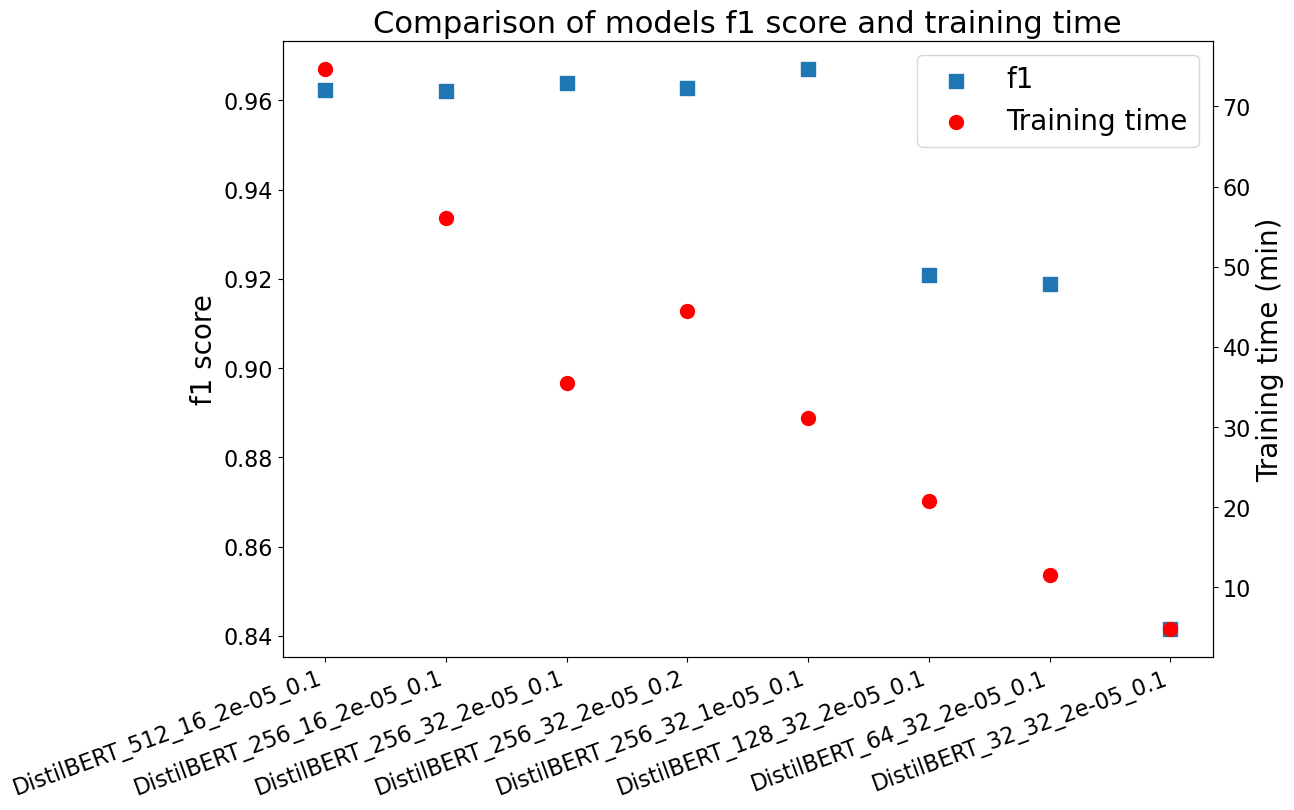

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(model_selection["model_id"], model_selection["test_f1_score"], s=100, marker="s", label="f1")
ax.set_xticklabels(model_selection["model_id"], rotation=20, ha="right")
ax2 = ax.twinx()
ax2.scatter(model_selection["model_id"], model_selection["training_time"] / 60, color="r", s=100, label="Training time")
ax.tick_params(axis="both", which="major", labelsize=16)
ax2.tick_params(axis="y", which="major", labelsize=16)
ax.set_ylabel("f1 score", fontsize=20)
ax2.set_ylabel("Training time (min)", fontsize=20)
ax.set_title("Comparison of models f1 score and training time", fontsize=22)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0, fontsize=20)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We have trained seven different versions of our DistilBERT classifier, varying several hyperparameters such as the maximum number of tokens, the learning rate, the dropout rate, and the batch size. The graph above shows the score and training time for each of them.  

As expected, the model with 512 tokens took the longest to train. However, surprisingly, it was not the best-performing one, as we found a 256-token model with a better F1-score and a much shorter training time. This model, `DistilBERT_256_32_1e-05_0.1`, is the one we will select and send for deployment. While the 512-token model could potentially outperform the 256-token model with further hyperparameter tuning, its long training time makes it less practical, especially since our model maintenance requires periodic retraining.  

We could have also used Longformer or a sliding window approach to bypass the token limit. However, considering the performance of our models and the marginal improvement from increasing the number of tokens—along with the extra training time required—this does not seem like a worthwhile trade-off.  

Interestingly, our model’s performance remains acceptable even when we further decrease the number of tokens. The F1-score stays around 0.9 with a maximum of 64 tokens and only starts to drop significantly when reduced to 32 tokens, though it remains reasonable. This suggests that our model can infer whether a news article is true or fake just by analyzing the beginning of the text. This behavior is similar to sentiment analysis models, which often rely on the first few words of a text since they contain the most critical information.  
</div>

In [17]:
classifier = TextNewsModule.load_from_checkpoint(
    "../model_ckpt/DistilBERT_256_32_1e-05_0.1.ckpt",
    neural_net=model,
    criterion=criterion,
    optimizer=optimizer,
)

best_model = classifier.neural_net

## **Investigating the mistakes**

In [18]:
test_results = pd.read_csv("../logs/test_results_DistilBERT_256_32_1e-05_0.1.csv")
test_results = pd.concat([X_test, test_results], axis=1)
test_results.head(5)

,text,ids,probas,predictions,labels
0,Japan is preparing to acquire precision air-la...,0,0.998706,1,1
1,Iran has sentenced to death a person found gui...,1,0.001858,0,0
2,Russia s military forces in Syria are likely t...,2,0.999673,1,1
3,"ARLINGTON, Va. (Reuters) - Washington has dram...",3,0.947025,1,1
4,Former Virginia Governor Jim Gilmore ended his...,4,0.002459,0,0


In [19]:
mistakes = test_results[test_results["predictions"] != test_results["labels"]]
false_negatives = mistakes[mistakes["labels"] == 1]
false_positives = mistakes[mistakes["labels"] == 0]

In [20]:
false_negatives

,text,ids,probas,predictions,labels
27,In a scene reminiscent of a horrifying KKK ral...,27,0.194900,0,1
346,Wow!Hillary s got the governor of Iowa shaking...,346,0.455114,0,1
548,As I was scrolling through my Twitter feed thi...,548,0.417987,0,1
674,U.S. President Donald Trump spoke by phone to ...,674,0.412490,0,1
1105,Republican front runner Donald Trump loves to ...,1105,0.279535,0,1
1384,European countries are scrambling to cobble to...,1384,0.044103,0,1
1618,The United Nations mission in Afghanistan said...,1618,0.035135,0,1
1685,China s Defense Ministry said on Thursday that...,1685,0.040366,0,1
2787,"KHOBAR, Saudi Arabia (Reuters) - Saudi Arabia ...",2787,0.290481,0,1
3136,The Trump administration does not want to refo...,3136,0.124694,0,1


In [29]:
false_positives

,text,ids,probas,predictions,labels,number_tokens
10,Islamic State beheaded 15 of its own fighters ...,10,0.558023,1,0,470
53,Conservatives are damned liars and they need t...,53,0.684612,1,0,856
72,"Yesterday was a big day for Trump supporters, ...",72,0.817769,1,0,1323
84,Before the leaked tape of Donald Trump describ...,84,0.567106,1,0,608
90,A Russian court sentenced opposition leader Al...,90,0.941016,1,0,296
...,...,...,...,...,...,...
7311,Microsoft Corp said on Monday it was looking i...,7311,0.709151,1,0,108
7371,Britain proposed a new post-Brexit security tr...,7371,0.968755,1,0,548
7454,"Michigan Governor Rick Snyder, facing protests...",7454,0.696845,1,0,525
7457,Donald Trump s best efforts to smear Democrati...,7457,0.620325,1,0,443


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The first thing we notice is that our model makes more false positives than false negatives; in other words, it more often mistakes true news for bad news. Looking at their indices, they do not appear to come particularly from the rewritten set of news.

Upon closer inspection, our mistakes all seem to be professionally written. Since our model processes only a limited number of tokens, this constraint might be contributing to these errors. Let's investigate further.
</div>

/tmp/ipykernel_26386/1037818314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives.loc[:, "number_tokens"] = false_positives["text"].apply(partial(number_of_tokens, tokenizer=tokenizer))
/tmp/ipykernel_26386/1037818314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives.loc[:, "number_tokens"] = false_negatives["text"].apply(partial(number_of_tokens, tokenizer=tokenizer))


Text(0, 0.5, 'Distribution of the number of tokens')

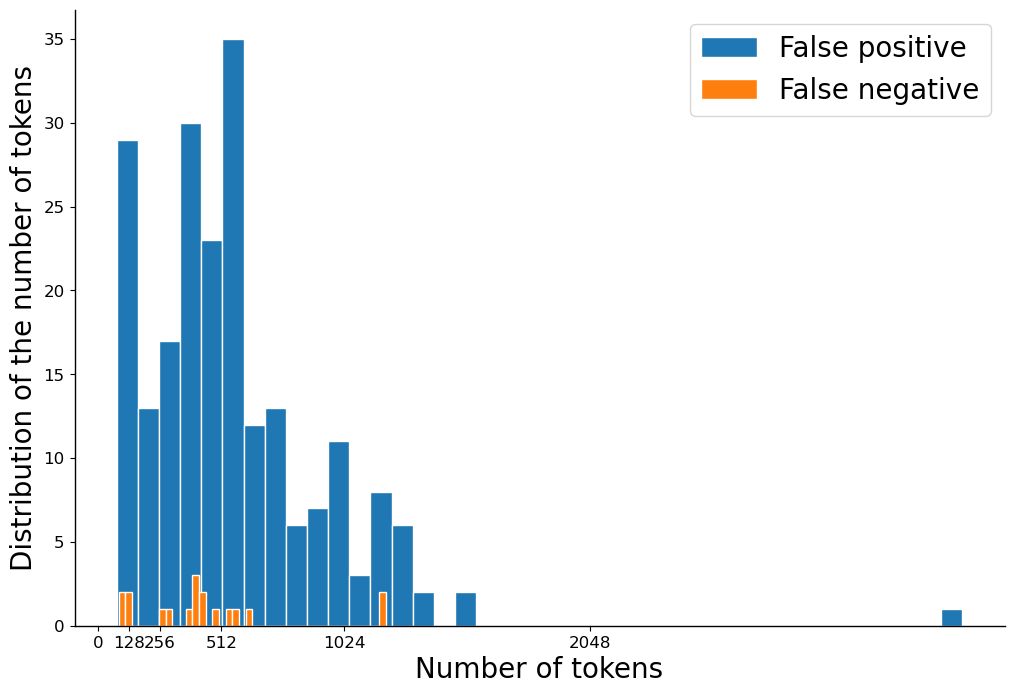

In [22]:
false_positives.loc[:, "number_tokens"] = false_positives["text"].apply(partial(number_of_tokens, tokenizer=tokenizer))
false_negatives.loc[:, "number_tokens"] = false_negatives["text"].apply(partial(number_of_tokens, tokenizer=tokenizer))

fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(false_positives["number_tokens"], bins=40, edgecolor="w", label="False positive")
ax.hist(false_negatives["number_tokens"], bins=40, edgecolor="w", label="False negative")
ax.set_xticks([0, 128, 256, 512, 1024, 2048])
ax.set_xticklabels([0, 128, 256, 512, 1024, 2048])
Rstyle_spines(ax, lw=1)
ax.legend(fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Number of tokens", fontsize=20)
ax.set_ylabel("Distribution of the number of tokens", fontsize=20)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The histogram above suggests that our concern about false negatives may be justified, as most of them contain more than 256 tokens. On the other hand, we detect a large number of "short" false positives. Let's print them out and see if we can identify any patterns.
</div>

In [23]:
short_false_positives = false_positives[false_positives["number_tokens"] < 256]
short_false_positives.head(10)

,text,ids,probas,predictions,labels,number_tokens
306,Silicon Valley heavyweight Peter Thiel will gi...,306,0.602057,1,0,207
1003,Saudi Arabia’s Deputy Crown Prince Mohammed bi...,1003,0.973884,1,0,182
1265,President Barack Obama did not specify a candi...,1265,0.843047,1,0,86
1273,The U.S. Senate Budget Committee voted along p...,1273,0.652672,1,0,113
1316,Sweden s center-right opposition no longer pla...,1316,0.567909,1,0,254
2161,Compare the US Debt burden under former Presid...,2161,0.996719,1,0,88
2185,Tunisia s navy has recovered 26 more bodies of...,2185,0.987516,1,0,223
2265,Honduran center-left candidate Salvador Nasral...,2265,0.577032,1,0,140
2524,"Boom!Dear Abby,My husband is a liar and a chea...",2524,0.991461,1,0,198
2601,The United States military has not changed its...,2601,0.829282,1,0,97


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
A quick glance at the false positives dataset suggests that these news articles focus on President Donald Trump. It is difficult to understand why such terms would make a difference, as they were anonymized during training. We may gain more insight into these errors once we develop a method to interpret our model.
</div>

## **Model explainability**

In [24]:
def predict_proba(texts):
    probas = []
    for text in texts:
        encoding = tokenizer.encode_plus(
          text,
          truncation=True,
          add_special_tokens=True,
          max_length=TOKEN_MAX,
          return_token_type_ids=False,
          padding="max_length",
          return_attention_mask=True,
          return_tensors='pt',
        )
        with torch.no_grad():
            logits = best_model(encoding['input_ids'].to("cuda"), encoding['attention_mask'].to("cuda"))
            prob = torch.sigmoid(logits).item()
            probas.append(np.array([1 - prob, prob]))
    return np.array(probas)

In [26]:
explainer = LimeTextExplainer(class_names=[0, 1])
explanation = explainer.explain_instance(
    short_false_positives["text"].iloc[0],
    predict_proba,
    num_features=10 
)
explanation.show_in_notebook()

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We can use the LIME explainer on every mistake, but it does not seem to isolate any specific pattern. However, it is quite surprising how it often focuses on small stop words such as he or his. Additionally, the names of organizations or personalities (regardless of who they are) always seem to be particularly important. Could this be due to the capital letters they contain? In the future, it would be worth trying a different tokenizer or preprocessing step.
</div>

## **Conclusion and future works**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
In this project, we've:

* Implemented several models to classify news.
* Evaluated and ranked each model based on their performance and their training time
* Used various resources to gain a deeper understanding of how predictions are made.
* Finally, we ended up with a model whose predictability power was evaluated based on its F1 score, which was around 0.96.

In the future, it would be interesting to:

* Try different model architectures or simply extend the classifier to see if a more complex dense layer would be sufficient to build a powerful predictor.
* Stack different models, some not based on transformers, and see if this can outperform our current model.
</div>